# Vector Converter

## Step 1. Import needed packages

Importing all the packages we need for our model

In [22]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import pyplot from matplotlib
import matplotlib.pyplot as plt

# Import TensorFlow & Keras 
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as tf_backend 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint

# Import all other needed packages
import numpy as np
import csv
from PIL import Image
import random
import os
import json

%matplotlib inline

## Step 2. Generate train & test datasets

Given the dataset $\mathcal{D} = \{ \{\mathbf{x}_k\}_{k=1}^M, \{y_k\}_{k=1}^M \}$ we split it into two other datasets:

$$
\mathcal{D}_{\text{train}} = \{ \{ \mathbf{x}_k\}_{k=1}^{\lfloor\eta M\rfloor}, \{y_k\}_{k=1}^{\lfloor\eta M\rfloor} \} 
$$
$$
\mathcal{D}_{\text{test}} = \{ \{ \mathbf{x}_k \}_{k=\lceil\eta M\rceil}^{M}, \{y_k\}_{k=\lceil\eta M\rceil}^{M} \}
$$

Where $\eta = 0.8$ is a proportion we allocate for a train part of the dataset

Here we simply import our $\texttt{csv}$ file and import all the vectors into $\texttt{feature_vector_batches_np}$, $\texttt{feature_vector_batches_tf}$, and $\texttt{labels}$.

In [24]:
# Forming feature vectors dictionary
feature_vectors_dictionary = {}

with open('./csv_datasets/keras_facenet_feature_vectors.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for i, row in enumerate(reader):
        if i == 0:
            continue
        
        person_id = int(float(row[0]))
        feature_vector = np.array(row[2:])
        feature_vector = feature_vector.astype(np.float)
        
        if person_id not in feature_vectors_dictionary:
            feature_vectors_dictionary[person_id] = [feature_vector]
            continue
            
        feature_vectors_dictionary[person_id].append(feature_vector)

dictionary_values = list(feature_vectors_dictionary.values()) 
        
# Finding minimal array size
min_array_length = int(1e10)
for value in dictionary_values:
    min_array_length = min(min_array_length, len(value))

# Forming tensorflow and numpy arrays
feature_vector_batches_np = []
feature_vector_batches_tf = []
labels = []

for key in feature_vectors_dictionary:
    value = feature_vectors_dictionary[key]
    value_np = np.array(value[:min_array_length])
    labels.extend([key] * min_array_length)
    feature_vector_batches_np.extend(value_np)
    feature_vector_batches_tf.extend(tf.convert_to_tensor(value_np))

Then we shuffle $\texttt{feature_vector_batches_np}$, $\texttt{feature_vector_batches_tf}$, and $\texttt{labels}$ together 

In [25]:
# Shuffle two lists
temp = list(zip(feature_vector_batches_np, feature_vector_batches_tf, labels))
random.shuffle(temp)
temp_batches_np, temp_batches_tf, temp_labels = zip(*temp)
feature_vector_batches_np, feature_vector_batches_tf, labels = list(temp_batches_np), list(temp_batches_tf), list(temp_labels)

feature_vector_batches_tf = tf.stack(feature_vector_batches_tf)

Just to make sure our code is properly written, we define the distance function $d_f(\mathbf{x}_1,\mathbf{x}_2) = \| \mathbf{x}_1 - \mathbf{x}_2\|_2^2$.
Then we take the first element in $\texttt{feature_vector_batches_tf}$ and find $\texttt{negative}+\texttt{positive}$ elements in it, which basically correspond to a feature vector of different and the same person, respectively. Distance between our anchor and $\texttt{positive}$ must be smaller than anchor and $\texttt{negative}$. 

In [26]:
# Test shuffling
def euclidean_distance(f1, f2):
    return tf.reduce_sum(tf.square(f1-f2), axis=0)

anchor, anchor_label = feature_vector_batches_tf[0], labels[0]

positive_id, negative_id = -1, -1 
for i, vector in enumerate(feature_vector_batches_np):
    if i == 0:
        continue
    if positive_id >= 0 and negative_id >= 0:
        break
    if labels[i] != anchor_label and negative_id == -1:
        negative_id = i
    if labels[i] == anchor_label and positive_id == -1:
        positive_id = i

negative, positive = feature_vector_batches_tf[negative_id], feature_vector_batches_tf[positive_id]
negative_label, positive_label = labels[negative_id], labels[positive_id]
        
print('Anchor, Negative, and Positive labels are {}, {}, and {}'.format(anchor_label, negative_label, positive_label))
print('Distance between anchor and negative is {}'.format(euclidean_distance(anchor, negative)))
print('Distance between anchor and positive is {}'.format(euclidean_distance(anchor, positive)))    

Anchor, Negative, and Positive labels are 119, 200, and 119
Distance between anchor and negative is 253.54916264945064
Distance between anchor and positive is 39.437943012123455


Then divide the dataset into $X_{\text{train}}, Y_{\text{train}}$ - a set of train vectors and labels, and $X_{\text{test}}, Y_{\text{test}}$ - a set of test vectors and labels.

In [27]:
# Splitting into training and test sets
total_dataset_length = len(labels)
test_proportion = 0.8
train_length = int(test_proportion * total_dataset_length)

X_train = feature_vector_batches_tf[:train_length]
Y_train = labels[:train_length]

X_test = feature_vector_batches_tf[train_length:]
Y_test = labels[train_length:]

num_classes = len(np.unique(Y_train))

print('Total dataset length: {}'.format(total_dataset_length))
print('Length of a train dataset: {}'.format(len(X_train)))
print('Length of a test dataset: {}'.format(len(X_test)))

Total dataset length: 5512
Length of a train dataset: 4409
Length of a test dataset: 1103


## Step 3. Define distance function

Continuous binary distance is defined as follows:
$$
\hat{\delta}(\mathbf{x}, \mathbf{y}) = \frac{1}{N}\sum_{k=1}^N |x_k - y_k|
$$

In [28]:
def binary_distance(x,y):
    return tf.reduce_mean(tf.abs(x-y),axis=0)

# Check binary distance formula
s1 = tf.constant([0.0, 0.0, 1.0, 1.0])
s2 = tf.constant([0.0, 0.0, 1.0, 0.0])
print(binary_distance(s1, s2))

def convert_to_binary_string(x):
    return tf.where(tf.less(x, 0.5), 0.0, 1.0)

x = tf.constant([0.001, 0.98, 0.1, 0.2, 0.78])
print(convert_to_binary_string(x))

tf.Tensor(0.25, shape=(), dtype=float32)
tf.Tensor([0. 1. 0. 0. 1.], shape=(5,), dtype=float32)


## Step 4. Creating functions to create batches & triplets

In [29]:
def create_batch(batch_size=256, split = "train"):
    x_anchors = np.zeros((batch_size, 128))
    x_positives = np.zeros((batch_size, 128))
    x_negatives = np.zeros((batch_size, 128))
    
    if split == "train":
        data = X_train
        data_y = Y_train
    elif split == "test":
        data = X_test
        data_y = Y_test
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, data.shape[0] - 1)
        x_anchor = data[random_index]
        y = data_y[random_index]
        
        indices_for_pos = [index for index in data_y if index == y]
        indices_for_neg = [index for index in data_y if index != y]
        
        x_positive = data[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = data[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

In [30]:
def create_hard_batch(batch_size, num_hard, split="train"):
    x_anchors = np.zeros((batch_size, 128))
    x_positives = np.zeros((batch_size, 128))
    x_negatives = np.zeros((batch_size, 128))
    
    if split == "train":
        data = X_train
        data_y = Y_train
    elif split == "test":
        data = X_test
        data_y = Y_test
    
    # Generate num_hard number of hard examples:
    hard_batches = [] 
    batch_losses = []
    rand_batches = []
    
    # Get some random batches
    for i in range(0, batch_size):
        hard_batches.append(create_batch(1, split))
        
        A_emb = embedding_model.predict(hard_batches[i][0])
        P_emb = embedding_model.predict(hard_batches[i][1])
        N_emb = embedding_model.predict(hard_batches[i][2])
        
        # Compute d(A, P) - d(A, N) for each selected batch
        batch_loss = binary_distance(A_emb[0], P_emb[0]) - binary_distance(A_emb[0], N_emb[0])
        batch_losses.append(batch_loss)
    
    # Sort batch_loss by distance, highest first, and keep num_hard of them
    zipped = zip(batch_losses, hard_batches)
    hard_batch_selections = [x for _, x in sorted(zipped, key=lambda x: x[0])]
    hard_batches = hard_batch_selections[:num_hard]
    
    # Get batch_size - num_hard number of random examples
    num_rand = batch_size - num_hard
    for i in range(0, num_rand):
        rand_batch = create_batch(1, split)
        rand_batches.append(rand_batch)
    
    selections = hard_batches + rand_batches
    
    for i in range(0, len(selections)):
        x_anchors[i] = selections[i][0]
        x_positives[i] = selections[i][1]
        x_negatives[i] = selections[i][2]
        
    return [x_anchors, x_positives, x_negatives]

## Step 5. Creating SNN

### Custom activation

In [31]:
from tensorflow.keras.regularizers import l2

# Model would consist of 3 dense layers of the same length as of feature vectors
def init_embedding_model():
    embedding_model = keras.Sequential([
        layers.Dense(
            20,
            input_shape=(128,),
            activation='relu',
            name='input_layer',
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(1e-3)),
        layers.Dense(
            128,  
            name="output_layer",
            activation = lambda x: 1/(1+tf.math.exp(-20.0*x)))
    ])
    
    embedding_model.summary()
    return embedding_model

def init_snn(embedding_model):
    input_anchor = layers.Input(shape=(128,))
    input_positive = layers.Input(shape=(128,))
    input_negative = layers.Input(shape=(128,))

    embedding_anchor = embedding_model(input_anchor)
    embedding_positive = embedding_model(input_positive)
    embedding_negative = embedding_model(input_negative)

    output = layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)
    
    siamese_net = keras.models.Model([input_anchor, input_positive, input_negative], output)
    siamese_net.summary()
    
    return siamese_net

Epsilon-loss

$$
\mathcal{L}_{\epsilon}(\mathbf{x}) = \Lambda \sum_{i=1}^{N} [\epsilon - |x_i|]_+
$$

Max epsilon-loss error
$$
\mathcal{L}_{\epsilon}^{\max} = \Lambda \cdot 3N \epsilon
$$
We want
$$
\mathcal{L}_{\epsilon} \approx 2\Theta
$$
Therefore
$$
\Lambda \approx \frac{2\Theta}{3N\epsilon}
$$

In [32]:
alpha = 0.3
epsilon = 0.05
loss_amplitude = alpha/(3*128*epsilon)

def epsilon_loss(x):
    return loss_amplitude * tf.reduce_sum(tf.maximum(tf.ones((128*3,))*epsilon - tf.math.abs(x), 0))

l = tf.ones(shape=(128*3,)) * (0)
print(epsilon_loss(l))

tf.Tensor(0.29999998, shape=(), dtype=float32)


In [34]:
distance_loss_ratio = 0.9

def combined_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:128], y_pred[:,128:2*128],y_pred[:,2*128:]
    
    positive_distance = tf.reduce_mean(tf.math.abs(anchor - positive))
    negative_distance = tf.reduce_mean(tf.math.abs(anchor - negative))
    
    distance_loss = distance_loss_ratio * tf.maximum(positive_distance - negative_distance + alpha, 0.)
    eps_loss = (1 - distance_loss_ratio) * epsilon_loss(y_pred) 
    return distance_loss + eps_loss

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:128], y_pred[:,128:2*128],y_pred[:,2*128:]
    
    positive_distance = tf.reduce_mean(tf.math.abs(anchor - positive))
    negative_distance = tf.reduce_mean(tf.math.abs(anchor - negative))
    
    return tf.maximum(positive_distance - negative_distance + alpha, 0.)


def epsilon_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:128], y_pred[:,128:2*128],y_pred[:,2*128:]
    return epsilon_loss(y_pred) 

In [35]:
def data_generator(batch_size=256, num_hard=50, split="train"):
    while True:
        x = create_hard_batch(batch_size, num_hard, split)
        y = np.zeros((batch_size, 3*128))
        yield x, y

## Step 6. Setting up for training and evaluation

In [36]:
# Hyperparams
batch_size = 256
epochs = 10
steps_per_epoch = int(X_train.shape[0]/batch_size)
val_steps = int(X_test.shape[0]/batch_size)
alpha = 0.3
num_hard = int(batch_size * 0.5) # Number of semi-hard triplet examples in the batch
lr = 0.001
optimiser = 'Adam'

with tf.device("/cpu:0"):
    # Create the embedding model
    print("Generating embedding model... \n")
    embedding_model = init_embedding_model()
    
    print("\nGenerating SNN... \n")
    # Create the SNN
    siamese_net = init_snn(embedding_model)
    # Compile the SNN
    optimiser_obj = Adam(lr = lr)
    siamese_net.compile(loss=[triplet_loss, epsilon_loss], optimizer=optimiser_obj)

Generating embedding model... 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 20)                2580      
                                                                 
 output_layer (Dense)        (None, 128)               2688      
                                                                 
Total params: 5,268
Trainable params: 5,268
Non-trainable params: 0
_________________________________________________________________

Generating SNN... 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                 

## Step 7. Testing model output

In [15]:
X_test_converted = embedding_model.predict(X_test)

print('Prediction:', X_test_converted[0][:10])

Prediction: [9.8511642e-01 7.5483108e-08 1.5013624e-03 4.2824540e-03 9.9995816e-01
 7.1395785e-01 2.9228986e-09 1.4346215e-07 8.5831791e-02 3.2549873e-01]


In [16]:
examples = create_batch(1)
print("Example triplet batch:")
print("Distance AP:", binary_distance(examples[0][0], examples[1][0]))
print("Distance AN:", binary_distance(examples[0][0], examples[2][0]))

print("Example semi-hard triplet batch:")
# 1 example, containing 1 semi-hard
ex_hard = create_hard_batch(2, 1, split="train")
print("Distance AP:", binary_distance(ex_hard[0][0], ex_hard[1][0]))
print("Distance AN:", binary_distance(ex_hard[0][0], ex_hard[2][0]))

Example triplet batch:
Distance AP: tf.Tensor(1.1315948822448263, shape=(), dtype=float64)
Distance AN: tf.Tensor(1.2810796184203355, shape=(), dtype=float64)
Example semi-hard triplet batch:
Distance AP: tf.Tensor(1.14570459688548, shape=(), dtype=float64)
Distance AN: tf.Tensor(1.0716196739231236, shape=(), dtype=float64)


## Step 8. Logging

In [17]:
# Set up logging directory
## Use date-time as logdir name:
#dt = datetime.now().strftime("%Y%m%dT%H%M")
#logdir = os.path.join("PATH/TO/LOG",dt)

## Use a custom non-dt name:
name = "snn-run"
logdir = os.path.join("./log",name)

if not os.path.exists(logdir):
    os.mkdir(logdir)

## Callbacks:
# Create the TensorBoard callback
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir = logdir,
    histogram_freq=0,
    batch_size=batch_size,
    write_graph=True,
    write_grads=True, 
    write_images = True, 
    update_freq = 'epoch', 
    profile_batch=0
)

# Training logger
csv_log = os.path.join(logdir, 'training.csv')
csv_logger = CSVLogger(csv_log, separator=',', append=True)

# Only save the best model weights based on the val_loss
checkpoint = ModelCheckpoint(os.path.join(logdir, 'snn_model-{epoch:02d}-{val_loss:.2f}.h5'),
                             monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=True, 
                             mode='auto')

# Save the embedding mode weights based on the main model's val loss
# This is needed to reecreate the emebedding model should we wish to visualise
# the latent space at the saved epoch
class SaveEmbeddingModelWeights(Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=1):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.best = np.Inf
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("SaveEmbeddingModelWeights requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.best:
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.verbose == 1:
                print("Saving embedding model weights at %s" % filepath)
            embedding_model.save_weights(filepath, overwrite = True)
            self.best = current
            
            # Delete the last best emb_model and snn_model
            delete_older_model_files(filepath)

# Save the embedding model weights if you save a new snn best model based on the model checkpoint above
emb_weight_saver = SaveEmbeddingModelWeights(os.path.join(logdir, 'emb_model-{epoch:02d}.h5'))


callbacks = [tensorboard, csv_logger, checkpoint, emb_weight_saver]


# Save model configs to JSON
model_json = siamese_net.to_json()
with open(os.path.join(logdir, "siamese_config.json"), "w") as json_file:
    json_file.write(model_json)
    json_file.close()
    
model_json = embedding_model.to_json()
with open(os.path.join(logdir, "embedding_config.json"), "w") as json_file:
    json_file.write(model_json)
    json_file.close()
    

hyperparams = {'batch_size' : batch_size,
              'epochs' : epochs, 
               'steps_per_epoch' : steps_per_epoch, 
               'val_steps' : val_steps, 
               'alpha' : alpha, 
               'num_hard' : num_hard, 
               'optimiser' : optimiser,
               'lr' : lr,
               'emb_size' : 128
              }


with open(os.path.join(logdir, "hyperparams.json"), "w") as json_file:
    json.dump(hyperparams, json_file)
    
# Set the model to TB
tensorboard.set_model(siamese_net)

def delete_older_model_files(filepath):
    
    model_dir = filepath.split("emb_model")[0]
    
    # Get model files
    model_files = os.listdir(model_dir)
    # Get only the emb_model files
    emb_model_files = [file for file in model_files if "emb_model" in file]
    # Get the epoch nums of the emb_model_files
    emb_model_files_epoch_nums = [file.split("-")[1].split(".h5")[0] for file in emb_model_files]

    # Find all the snn model files
    snn_model_files = [file for file in model_files if "snn_model" in file]

    # Sort, get highest epoch num
    emb_model_files_epoch_nums.sort()
    highest_epoch_num = emb_model_files_epoch_nums[-1]

    # Filter the emb_model and snn_model file lists to remove the highest epoch number ones
    emb_model_files_without_highest = [file for file in emb_model_files if highest_epoch_num not in file]
    snn_model_files_without_highest = [file for file in snn_model_files if highest_epoch_num not in file]

    # Delete the non-highest model files from the subdir
    if len(emb_model_files_without_highest) != 0:
        print("Deleting previous best model file:", emb_model_files_without_highest)
        for model_file_list in [emb_model_files_without_highest, snn_model_files_without_highest]:
            for file in model_file_list:
                os.remove(os.path.join(model_dir, file))

## Step 9. Training

In [17]:
## Training:
print("Logging out to Tensorboard at:", logdir)
print("Starting training process!")
print("-------------------------------------")

siamese_net.compile(loss=triplet_loss, optimizer=optimiser_obj)

siamese_history = siamese_net.fit(
    data_generator(int(batch_size), num_hard),
    steps_per_epoch=steps_per_epoch,
    epochs=18,
    verbose=1,
    callbacks=callbacks, 
    workers = 0, 
    validation_data = data_generator(int(batch_size), num_hard, split="test"), 
    validation_steps = val_steps)

print("-------------------------------------")
print("Training complete.")

Logging out to Tensorboard at: ./log/snn-run
Starting training process!
-------------------------------------
Epoch 1/18
17/17 [==============================] - ETA: 0s - loss: 0.2864  
Epoch 1: val_loss improved from inf to 0.30532, saving model to ./log/snn-run/snn_model-01-0.31.h5
Saving embedding model weights at ./log/snn-run/emb_model-01.h5
Deleting previous best model file: ['emb_model-01.h5']
17/17 [==============================] - 1590s 99s/step - loss: 0.2864 - val_loss: 0.3053
Epoch 2/18
17/17 [==============================] - ETA: 0s - loss: 0.2575  
Epoch 2: val_loss improved from 0.30532 to 0.28936, saving model to ./log/snn-run/snn_model-02-0.29.h5
Saving embedding model weights at ./log/snn-run/emb_model-02.h5
Deleting previous best model file: ['emb_model-02.h5']
17/17 [==============================] - 1633s 97s/step - loss: 0.2575 - val_loss: 0.2894
Epoch 3/18
17/17 [==============================] - ETA: 0s - loss: 0.2340  
Epoch 3: val_loss did not improve from 

2023-01-31 10:54:50.546970: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled



Epoch 18: val_loss did not improve from 0.18308
17/17 [==============================] - 1710s 102s/step - loss: 0.0276 - val_loss: 0.1920
-------------------------------------
Training complete.


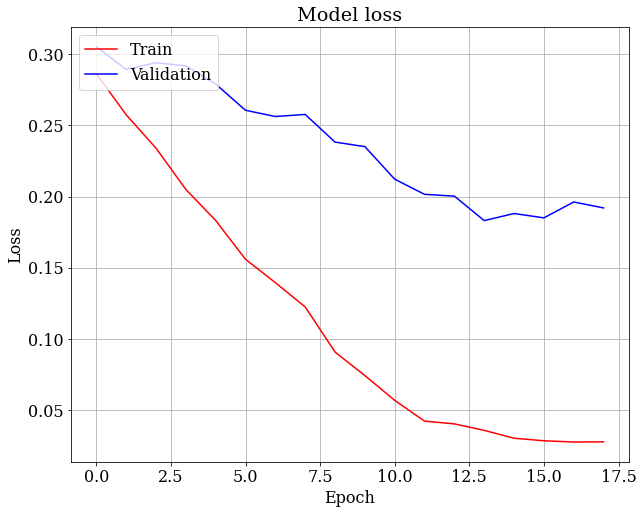

In [35]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
figure(figsize=(10, 8))
plt.plot(siamese_history.history['loss'], color='red')
plt.plot(siamese_history.history['val_loss'], color='blue')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()

plt.show()

In [18]:
import os

def json_to_dict(json_src):
    with open(json_src, 'r') as j:
        return json.loads(j.read())
      
## Load in best trained SNN and emb model

# The best performing model weights has the higher epoch number due to only saving the best weights
highest_epoch = 0
dir_list = os.listdir(logdir)

for file in dir_list:
    if file.endswith(".h5"):
        epoch_num = int(file.split("-")[1].split(".h5")[0])
        if epoch_num > highest_epoch:
            highest_epoch = epoch_num

# Find the embedding and SNN weights src for the highest_epoch (best) model
for file in dir_list:
    # Zfill ensure a leading 0 on number < 10
    if ("-" + str(highest_epoch).zfill(2)) in file:
        if file.startswith("emb"):
            embedding_weights_src = os.path.join(logdir, file)
        elif file.startswith("snn"):
            snn_weights_src = os.path.join(logdir, file)

hyperparams = os.path.join(logdir, "hyperparams.json")
snn_config = os.path.join(logdir, "siamese_config.json")
emb_config = os.path.join(logdir, "embedding_config.json")

snn_config = json_to_dict(snn_config)
emb_config = json_to_dict(emb_config)

# json.dumps to make the dict a string, as required by model_from_json
loaded_emb_model = init_embedding_model()
loaded_emb_model.load_weights(embedding_weights_src)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 20)                2580      
                                                                 
 output_layer (Dense)        (None, 128)               2688      
                                                                 
Total params: 5,268
Trainable params: 5,268
Non-trainable params: 0
_________________________________________________________________


In [19]:
X_test_predicted = embedding_model.predict(X_test)

same_sim, num_same = 0, 0
classes = np.unique(Y_test)

for c in classes:
    X_to_test = [convert_to_binary_string(x) for i,x in enumerate(X_test_predicted) if Y_test[i] == c]
    for i in range(len(X_to_test)-1):
        dist = binary_distance(X_to_test[i], X_to_test[i+1])
        same_sim += (1 - dist)
        num_same += 1

diff_sim, num_diff = 0, 0
for i in range(len(classes)-1):
    X1 = [convert_to_binary_string(x) for k,x in enumerate(X_test_predicted) if Y_test[k] == classes[i]]
    X2 = [convert_to_binary_string(x) for k,x in enumerate(X_test_predicted) if Y_test[k] == classes[i+1]]
    for j in range(min(len(X1),len(X2))):
        dist = binary_distance(X1[j], X2[j])
        diff_sim += (1 - dist)
        num_diff += 1

print('Same similarity', same_sim/num_same)
print('Diff similarity', diff_sim/num_diff)

Same similarity tf.Tensor(0.7669841, shape=(), dtype=float32)
Diff similarity tf.Tensor(0.61573076, shape=(), dtype=float32)


In [26]:
avg_same_sim, num_sim = 0, 0
classes = np.unique(Y_test)

for c in classes:
    X_to_test = [convert_to_binary_string(x) for i,x in enumerate(X_test) if Y_test[i] == c]
    for i in range(len(X_to_test)-1):
        dist = binary_distance(X_to_test[i], X_to_test[i+1])
        avg_same_sim += (1 - dist)
        num_sim += 1

avg_diff_sim, num_diff = 0, 0
for i in range(len(classes)-1):
    X1 = [convert_to_binary_string(x) for k,x in enumerate(X_test) if Y_test[k] == classes[i]]
    X2 = [convert_to_binary_string(x) for k,x in enumerate(X_test) if Y_test[k] == classes[i+1]]
    for j in range(min(len(X1),len(X2))):
        dist = binary_distance(X1[j], X2[j])
        avg_diff_sim += (1 - dist)
        num_diff += 1

print('Same similarity', avg_same_sim/num_sim)
print('Diff similarity', avg_diff_sim/num_diff)

Same similarity tf.Tensor(0.76985127, shape=(), dtype=float32)
Diff similarity tf.Tensor(0.58202666, shape=(), dtype=float32)
